# abessPCA
This notebook introduces what is sparse principal component analysis (SPCA) and use a real data example to show how to use our frame to form it. 

## Introduction
Principal component analysis (PCA) is an important method in the field of data science, which can reduce the dimension of data and simplify our model. It actually solve an optimization problem like:
$$
    \max_{v} v^T\Sigma v,\qquad s.t.\quad v^Tv=1.
$$
where $\Sigma = X^TX / (n-1)$ and $X$ is the **centered** sample matrix.

Then, before further analysis, we can project $X$ to $v$ (thus dimensional reduction), without losing too much information.

However, there are some obvious drawbacks on PCA: 
- The PC is a linear combination of all primary variables (Xv) and generally the loading $v$ is not sparse, so it is often hard to interpret our PC; 
- When analysing a new observation, we still have to collect data on all primary variables. That is, PCA does not help to reduce dimension on data collection. 

> For example, there maybe some irrelevant variables in our primary variables and PCA would take all of them in consideration. It is hard to find which variables are "actually useful" from the loading $v$, and to interpret the meaning of this PC.

As a result, it is important to not only reduce dimension of data, but try to **drop** useless variables (set the corresponding position in $v$ to 0). That is why Sparse-PCA (SPCA) comes.

Sparse-PCA (SPCA) also seeks for principal component, but with a sparsity limitation:
$$
    \max_{v} v^T\Sigma v,\qquad s.t.\quad v^Tv=1,\ ||v||_0\leq s.
$$
where $s$ is a non-negative integer, which indicates how many primary variables are used in principal component. 
With this sparse loading $v$, we can find the most important $s$ (or less) variables used in PCA and drop those unused ones.
> Clearly, if $s$ is equal or larger than the number of primary variables, this sparsity limitation is actually useless and the problem is equivalent to a simple PCA.

> With less variables, the PC must have lower explained variance. However, this decrease is slight if we choose a good $s$ and at this price, we can interpret the PC much better. It is worthy. 

Furthermore, some variables may need to consider together, that is, they should be "useful" or "useless" for PC at the same time, which we call "group information". The optimization problem becomes:
$$
    \max_{v} v^T\Sigma v,\qquad s.t.\quad v^Tv=1,\ \sum_{g=1}^G I(||v_g||\neq 0)\leq s.
$$
where we suppose there are $G$ groups, and the $g$-th one correspond to $v_g$, $v = [v_1^T,v_2^T,\cdots,v_G^T]^T$. Then we are interested to find $s$ (or less) important groups.
> Group problem is extraordinary important in real data analysis. For example, in gene sequence, several sites would be related to one charcter, and it is meaningless to consider each of them alone. 

In the next section, we will show how to form SPCA (as well as group-SPCA) in our frame.

## abessPCA
Here we will show how to use our frame (abess) to form SPCA. The data we use is from [UCI:
Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) and we pick up its 100 predictive variables as our samples.

- Initiation:

Firstly, we center the data and record its sample size $n$ as well as number of variables $p$.

In [31]:
import numpy as np
from abess.linear import abessPCA

X = np.genfromtxt('communities.data', delimiter = ',') 
X = X[:, 5:127]                         # numeric predictiors
X = X[:, ~np.isnan(X).any(axis = 0)]    # drop variables with nan

X = X - X.mean(axis = 0)                # centered data
n, p = X.shape

print(n)
print(p)


1994
99


- Model building:

To build a SPCA model, we need to give some parameters, such as the target sparisty. Our program can automatically find a best sparisty in a given range `range(s_begin, s_end + 1)`. We can also set `s_begin=s_end` for one fixed sparsity.

In [32]:
s_begin = 0         # min target sparsity
s_end = 20          # max targer sparsity

model = abessPCA(
    support_size = range(s_begin, s_end + 1)
)

- Fitting:

For fitting the model, we can give either $X$ or $Sigma = X^TX$. `is_normal = False` means that the program will not normalize $X$. Note that if both $X$ and $Sigma$ are given, the program prefer to use $X$.

In [33]:
model.fit(X, is_normal = False)  
# or give Sigma:
# model.fit(Sigma = X.T.dot(X))

abessPCA(support_size=range(0, 21))

- Result:

After fitting, `model.coef_` returns the sparse principal component and its non-zero positions correspond to variables used. 

In [34]:
print(model.coef_)

temp = np.nonzero(model.coef_)[0]
print('non-zero position: \n', temp)
print('chosen sparsity: ', temp.size)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.27618663
 -0.23703262  0.          0.          0.          0.          0.18384733
  0.         -0.2275236  -0.21204903 -0.19753942  0.          0.
  0.          0.          0.          0.21358573  0.          0.18270928
 -0.18928695  0.          0.          0.          0.          0.1760962
 -0.17481418  0.          0.          0.          0.          0.
  0.          0.         -0.18581084  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.23804122  0.
 -0.2415995  -0.24785373 -0.24947283 -0.23938391 -0.23605314 -0.28015859
 -0.23841083  0.          0.          0.          0

- Explained variance:

In [35]:
Xv = X.dot(model.coef_)
explained = Xv.T.dot(Xv)            # explained variance (information)
total = sum(np.diag(X.T.dot(X)))    # total variance (information)
print( 'explained ratio: ', explained / total )

explained ratio:  0.1692080282085568


- Analysis:

We can give different target sparsity (change `s_begin` and `s_end`) to get different sparse loading. It is clear that the higher sparsity is, the more variance it can explain. However, sometimes we seek for a smaller sparsity which can explain most of the variance.

In this example, if we try sparsities from $0$ to $p$, and calculate the ratio of explained variance:

In [36]:
num = 30
px = np.linspace(0, p, num, dtype='int')
py = np.zeros(num)
for i in range(num):
    model = abessPCA(
        support_size = range(px[i], px[i] + 1),
        exchange_num = int(px[i]),  
        max_iter=50
    )
    model.fit(X, is_normal = False)
    Xv = X.dot(model.coef_)
    py[i] = Xv.T.dot(Xv)

print('80%+ : ', px[py > 0.8 * py[num-1]])
print('90%+ : ', px[py > 0.9 * py[num-1]])

80%+ :  [34 37 40 44 47 51 54 58 61 64 68 71 75 78 81 85 88 92 95 99]
90%+ :  [44 47 51 54 58 61 64 68 71 75 78 81 85 88 92 95 99]


If we denote the explained ratio from all 99 variables as 100%, the curve indicates that at least 34 variables can reach 80% (blue dashed line) and 44 variables can reach 90% (red dashed line).

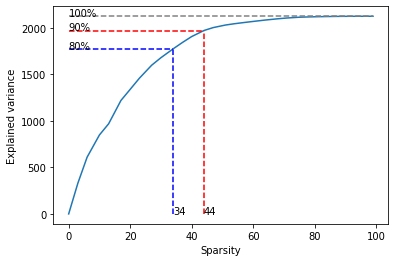

In [37]:
import matplotlib.pyplot as plt
plt.plot(px, py)
plt.xlabel('Sparsity')
plt.ylabel('Explained variance')

ind = np.where(py > 0.8 * py[num-1])[0][0]
plt.plot([0, px[ind]], [py[ind], py[ind]], 'b--')
plt.plot([px[ind], px[ind]], [0, py[ind]], 'b--')
plt.text(px[ind], 0, str(px[ind]))
plt.text(0, py[ind], '80%')

ind = np.where(py > 0.9 * py[num-1])[0][0]
plt.plot([0, px[ind]], [py[ind], py[ind]], 'r--')
plt.plot([px[ind], px[ind]], [0, py[ind]], 'r--')
plt.text(px[ind], 0, str(px[ind]))
plt.text(0, py[ind], '90%')

plt.plot([0, p], [py[num-1], py[num-1]], color='gray', linestyle='--')
plt.text(0, py[num-1],'100%')

plt.show()

This result shows that using less than half of all 99 variables can be close to perfect. For example, if we choose sparsity 34, the used variables are:

In [38]:
model = abessPCA(support_size = range(34, 35))
model.fit(X, is_normal = False)
temp = np.nonzero(model.coef_)[0]
print('non-zero position: \n', temp)

non-zero position: 
 [ 2  3 11 12 15 17 19 20 21 22 25 27 28 29 30 31 32 35 36 42 43 44 45 49
 66 76 77 78 79 80 81 82 83 84]


## Group abessPCA

Our program can also from SPCA with group information. Here we suppose that variables in the same group address close to each other (if not, the data should be sorted first).

Suppose that the data above have group information like:
- Group 0: {the 1st, 2nd, ..., 10th variable};
- Group 1: {the 11st, 12nd, ..., 20th variable};
- ...
- Group 9: {the 91st, 92nd, ..., 99th variable}.

Denote different groups as different number:  

In [39]:
g_info = np.arange(10) 
g_info = g_info.repeat(10)
g_info = g_info[0:99]

print(g_info)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9]


And fit a group SPCA model with additional argument `group=g_info`:

In [40]:
model = abessPCA(support_size=range(0, 5))
model.fit(X, group = g_info, is_normal = False) 

abessPCA(support_size=range(0, 5))

The result comes to:

In [41]:
print(model.coef_)

temp = np.nonzero(model.coef_)[0]
temp = np.unique(g_info[temp])

print('non-zero group: \n', temp)
print('chosen sparsity: ', temp.size)



[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00171271  0.2648612
  0.23062673  0.12734873 -0.03739316  0.16081814 -0.08529476 -0.18186216
 -0.00585155  0.21902021  0.20114511  0.1853583   0.13682873  0.05973876
  0.09974769  0.13851652 -0.02939782 -0.21621104 -0.16820857 -0.17753443
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.0212061   0.08496932
  0.09046897 -0.10846386 -0.07958145  0.0410962  -0.23518689 -0.11846002
  0.22968491  0.23447547  0.23450492  0.23280996  0.22757745  0.26878584
  0.23031387 -0.0260155   0.1056282

Hence we can focus on variables in Group 1,2,7,8.